# Model Experiments

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
import cv2
import matplotlib.pyplot as plt

In [6]:
# =======================
# Dataset Preparation
# =======================
class GlacierDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask > 0] = 1  # Ensure binary mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return T.ToTensor()(image), torch.tensor(mask, dtype=torch.long)


In [13]:
# =======================
# Training Setup
# =======================
# Paths
image_dir = "data/images"
mask_dir = "data/masks"

In [14]:
# Data loader
dataset = GlacierDataset(image_dir, mask_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [15]:
# Device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [16]:
# Model
num_classes = 2  # Background and glacier
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /Users/sachinmalego/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:03<00:00, 54.7MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [17]:
# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [18]:
# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")


Epoch [1/5], Loss: 0.1278
Epoch [2/5], Loss: 0.0622
Epoch [3/5], Loss: 0.0593
Epoch [4/5], Loss: 0.0512
Epoch [5/5], Loss: 0.0527


In [19]:
# Save model
torch.save(model.state_dict(), "glacier_segmentation.pth")

In [ ]:
# =======================
# Change Detection
# =======================
def predict_mask(image_path, model, device):
    # Check if the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read the image: {image_path}")

    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transform the image and predict the mask
    transform = T.Compose([T.ToTensor()])
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)['out'][0]
        mask = torch.argmax(output, dim=0).cpu().numpy()
    return mask

In [35]:
# Load the model
model.load_state_dict(torch.load("glacier_segmentation.pth"))
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [48]:
# Predict masks for "before" and "after" images
before_image_path = "before.png"
after_image_path = "after.png"

In [49]:
before_mask = predict_mask(before_image_path, model, device)
after_mask = predict_mask(after_image_path, model, device)

In [50]:
# Resize the masks to the same shape
target_shape = (min(before_mask.shape[1], after_mask.shape[1]), 
                min(before_mask.shape[0], after_mask.shape[0]))

before_mask_resized = cv2.resize(before_mask, target_shape, interpolation=cv2.INTER_NEAREST)
after_mask_resized = cv2.resize(after_mask, target_shape, interpolation=cv2.INTER_NEAREST)

# Difference mask
difference_mask = np.abs(before_mask_resized - after_mask_resized)

In [51]:
# Calculate changed area
changed_pixels = np.count_nonzero(difference_mask)
resolution = 30  # Example: 30m per pixel
area_change = changed_pixels * (resolution ** 2)
print(f"Changed Area: {area_change} square meters")

Changed Area: 465228000 square meters


In [ ]:
# =======================
# Visualization
# =======================
def overlay_mask(image_path, mask, color="red"):
    # Load the image
    image = cv2.imread(image_path)
    h, w = image.shape[:2]  # Get dimensions of the image

    # Resize the mask to match the image dimensions
    mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # Create a blank mask with 3 channels
    mask_colored = np.zeros((h, w, 3), dtype=np.uint8)

    # Assign the desired color to the mask
    if color == "red":
        mask_colored[:, :, 2] = mask_resized * 255  # Red channel
    elif color == "green":
        mask_colored[:, :, 1] = mask_resized * 255  # Green channel

    # Overlay the mask on the image
    overlay = cv2.addWeighted(image, 0.7, mask_colored, 0.3, 0)
    return overlay


In [ ]:
# Visualize "before", "after", and difference
# Overlay masks for visualization
before_overlay = overlay_mask(before_image_path, before_mask, color="red")
after_overlay = overlay_mask(after_image_path, after_mask, color="red")
difference_overlay = overlay_mask(before_image_path, difference_mask, color="green")  # Highlight changes in green

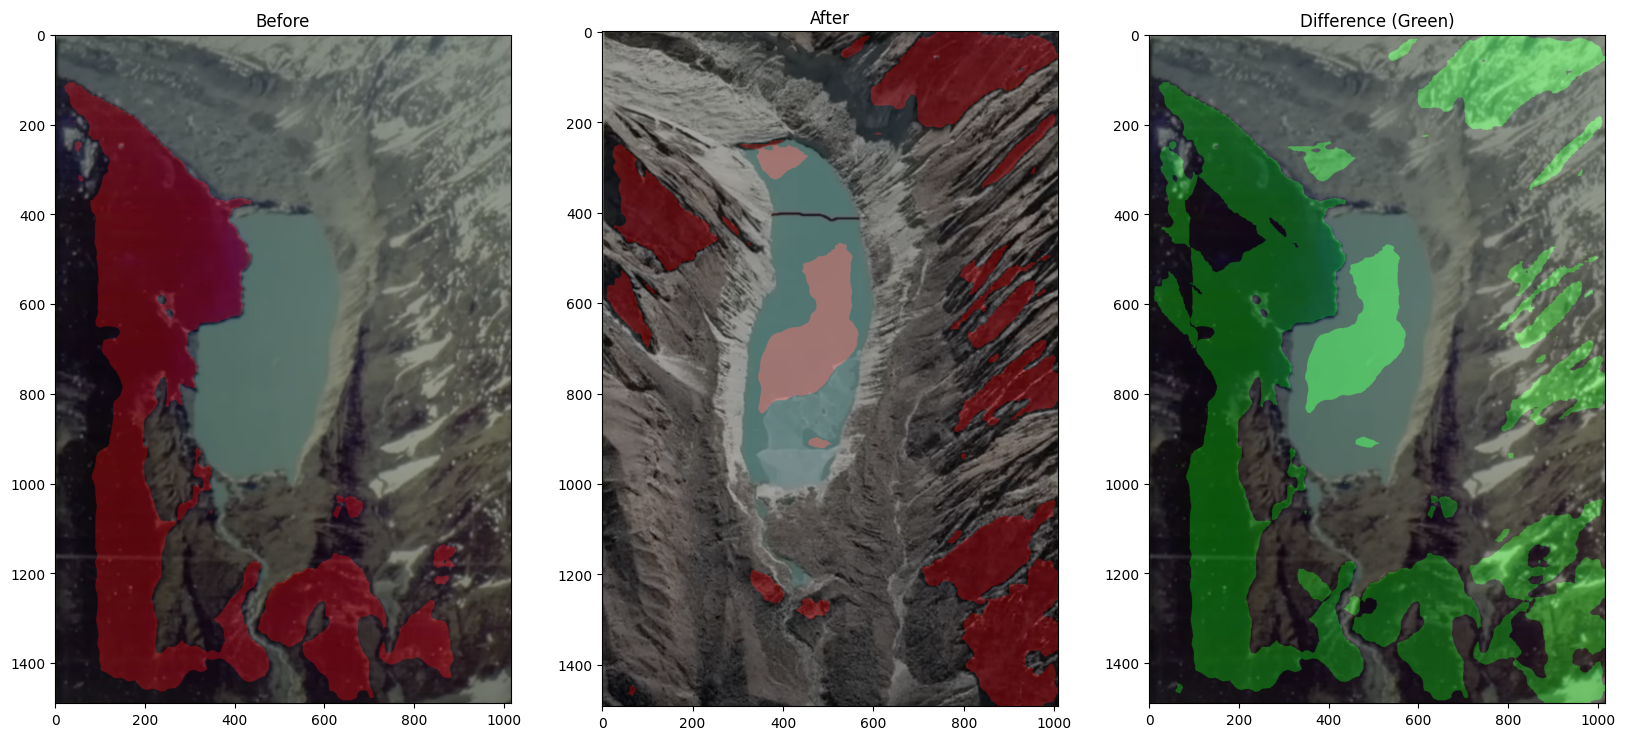

In [ ]:
# Visualize results
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title("Before")
plt.imshow(cv2.cvtColor(before_overlay, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("After")
plt.imshow(cv2.cvtColor(after_overlay, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Difference (Green)")
plt.imshow(cv2.cvtColor(difference_overlay, cv2.COLOR_BGR2RGB))
plt.show()